In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# read all the names in the dataset
words = open('names.txt',  'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [26]:
#building the vocabulary of characters and mapping them to integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [72]:
#build datasets

import random
random.seed(42)
random.shuffle(words)

block_size = 8 # context length
vocab_size = 27 # number of chars in our char vocabulary (total possible outputs)

def build_dataset(words):
    #dataset prep
    X, Y = [], []  
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])       #80%
Xdev, Ydev = build_dataset(words[n1:n2])   #10%
Xte, Yte = build_dataset(words[n2:])       #10%

In [103]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#----------------------------------------------------------------------------------

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters - trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # bufers - not trained with backprop but on the side with momentum to counter the batch norm on single input inference
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)   # deviation from pytorch api of batchnorm 1d
            xmean = x.mean(dim, keepdims=True)
            xvar = x.var(dim, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar+ self.eps) # normailise to unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

#----------------------------------------------------------------------------------

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

#----------------------------------------------------------------------------------

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

#----------------------------------------------------------------------------------

class FlattenConsecutive:
    def __init__(self,n):
        self.n = n
    
    def __call__(self, x):
        B, T , C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

#----------------------------------------------------------------------------------

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get params of all layers and stretch them out in a list
        return [p for layer in self.layers for p in layer.parameters()]


In [93]:
e = torch.rand(2,4,5)
print(e)
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim = 2)
explicit.shape

tensor([[[0.2426, 0.2421, 0.1212, 0.4667, 0.2890],
         [0.1994, 0.7011, 0.3390, 0.3446, 0.1463],
         [0.9329, 0.0946, 0.9430, 0.9449, 0.7383],
         [0.4461, 0.2553, 0.3626, 0.4104, 0.8764]],

        [[0.1668, 0.6314, 0.0032, 0.3051, 0.6897],
         [0.9747, 0.1389, 0.3259, 0.1637, 0.0536],
         [0.4721, 0.0195, 0.4694, 0.6308, 0.3432],
         [0.2243, 0.8664, 0.7440, 0.4259, 0.9516]]])


torch.Size([2, 2, 10])

In [104]:
torch.manual_seed(42);

In [129]:
n_embed = 27 # the dimensionality of the embedding lookup table\
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), 
])

with torch.no_grad():
    #last layer make less confident
    layers[-1].weight *= 0.1
    # all other linear layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 #5/3

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of params in total
for p in parameters:
    p.requires_grad = True

178156


In [130]:
max_steps = 300000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch contruct
    ix = torch.randint(1, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    #update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 300000: 3.9297
  10000/ 300000: 2.8028
  20000/ 300000: 2.0348
  30000/ 300000: 1.9492
  40000/ 300000: 1.8737
  50000/ 300000: 2.0661
  60000/ 300000: 1.5560
  70000/ 300000: 1.8592
  80000/ 300000: 1.9818
  90000/ 300000: 1.7388
 100000/ 300000: 2.2150
 110000/ 300000: 1.4097
 120000/ 300000: 2.5752
 130000/ 300000: 1.8993
 140000/ 300000: 2.0863
 150000/ 300000: 2.5696
 160000/ 300000: 1.4278
 170000/ 300000: 1.4402
 180000/ 300000: 1.7116
 190000/ 300000: 1.6640
 200000/ 300000: 1.5344
 210000/ 300000: 2.0958
 220000/ 300000: 1.8031
 230000/ 300000: 1.9973
 240000/ 300000: 1.9921
 250000/ 300000: 1.3821
 260000/ 300000: 1.3908
 270000/ 300000: 1.5628
 280000/ 300000: 1.6257
 290000/ 300000: 1.8150


In [131]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 27)
FlattenConsecutive : (32, 4, 54)
Linear : (32, 4, 200)
BatchNorm1d : (32, 4, 200)
Tanh : (32, 4, 200)
FlattenConsecutive : (32, 2, 400)
Linear : (32, 2, 200)
BatchNorm1d : (32, 2, 200)
Tanh : (32, 2, 200)
FlattenConsecutive : (32, 400)
Linear : (32, 200)
BatchNorm1d : (32, 200)
Tanh : (32, 200)
Linear : (32, 27)


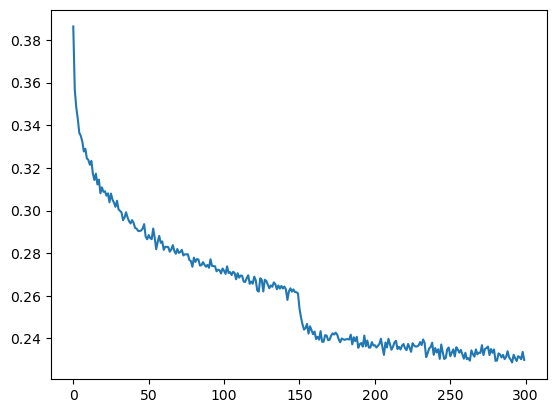

In [132]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) #takes avg loss of every 1000 iterations and plots that

In [133]:
for layer in model.layers:
    layer.training = False # to set the training flag in batchnorm layers as false

In [134]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train' : (Xtr, Ytr),
        'dev' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 1.6797455549240112
dev 2.0027761459350586


In [135]:
for _ in range(20):
    out = []
    context = [0] * block_size # initializing with . . .
    while True:
        #forward pass
        logits = model(torch.tensor([context]))
        probs = torch.softmax(logits, dim=1)
        #sample from the distribtion
        ix = torch.multinomial(probs, num_samples = 1).item()
        #shifting the context window
        context = context[1:] + [ix]
        out.append(ix)
        #if we encounted a special character
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) #decode and print the generated word

laref.
jaheem.
elizlynn.
maziah.
oryan.
kamrynn.
ellenah.
daimin.
aiyani.
jayshawn.
asahi.
kamel.
annaki.
shafeh.
ebugae.
analeigh.
aaryah.
carelle.
azrael.
henrix.
